<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_VAQ_VQE(MolecularGeometry)_mkbahk_20251208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Python 3.9 ~ 3.11 환경에서 아래 순서대로 설치
!pip install qiskit[visualization]==1.2.4
!pip install qiskit-aer==0.15.1
!pip install qiskit-algorithms==0.3.1
!pip install qiskit-nature[pyscf]==0.7.2
!pip install pyscf==2.6.0

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
"""
VQE (Variational Quantum Eigensolver) 구현
수소 분자(H2)의 바닥 상태 에너지 계산
"""

import numpy as np
import datetime
import time

from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper, TaperedQubitMapper, DirectMapper, QubitMapper

from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA, L_BFGS_B, SPSA, NFT, P_BFGS, QNSPSA, P_BFGS, ADAM, adam_amsgrad, NELDER_MEAD, POWELL, TNC, CG, NFT, IMFIL, SNOBFIT, BOBYQA, GSLS, AQGD
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, ExcitationPreserving, PauliTwoDesign, NLocal
from qiskit_aer import AerSimulator

print("=" * 60)
print("VQE를 이용한 분자 에너지 계산")
print("=" * 60)

VQE를 이용한 분자 에너지 계산


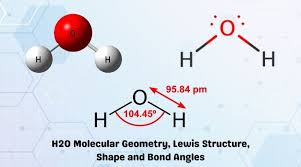

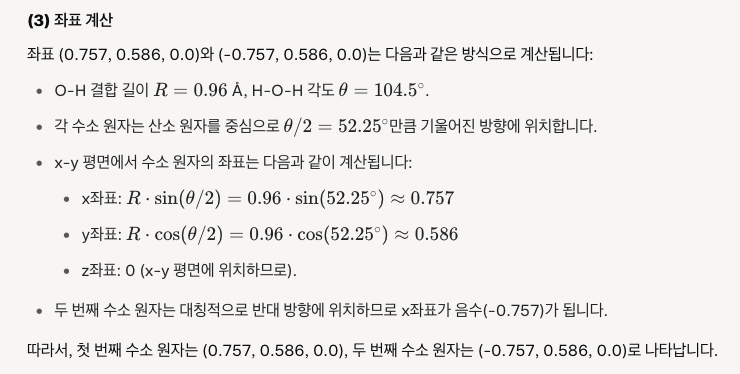

In [59]:
# 1. 분자 (구조)정의 (H2 분자)
print("\n[1단계] 분자 구조 정의")
print("-" * 60)

# 0. 수소분자 정의
#h2 =  "H 0.0 0.0 0.0; \
#       H 0.0 0.0 0.735"
# 0. 수소분자 정의
h2 =  "H 0.757 0.586 0.0; \
       H 0.757 0.585 0.0"


# 1. 물분자 H₂O (이미 있으시지만 참고용으로 다시)
h2o = "O 0.000000 0.000000 0.000000; \
       H 0.000000 0.757000 0.586000; \
       H 0.000000 -0.757000 0.586000"

# 2. 메탄 CH₄ (Td 대칭)
ch4 = "C 0.000000 0.000000 0.000000; \
       H 0.626800 0.626800 0.626800; \
       H 0.626800 -0.626800 -0.626800; \
       H -0.626800 0.626800 -0.626800; \
       H -0.626800 -0.626800 0.626800"

# 3. 에틸렌 C₂H₄ (D2h 대칭, 평면 구조)
c2h4 = "C 0.000000 0.000000 0.669500; \
        C 0.000000 0.000000 -0.669500; \
        H 0.928900 0.000000 1.237500; \
        H -0.928900 0.000000 1.237500; \
        H 0.928900 0.000000 -1.237500; \
        H -0.928900 0.000000 -1.237500"

# 4. 암모니아 NH₃ (C3v 대칭)
nh3 = "N 0.000000 0.000000 0.000000; \
       H 0.000000 0.951000 -0.267000; \
       H 0.823000 -0.475500 -0.267000; \
       H -0.823000 -0.475500 -0.267000"

# 5. 이산화탄소 CO₂ (D∞h 대칭, 선형)
co2 = "O -1.161000 0.000000 0.000000; \
       C  0.000000 0.000000 0.000000; \
       O  1.161000 0.000000 0.000000"

# 6. 보너스: 아세틸렌 C₂H₂ (D∞h 대칭, 선형)
c2h2 = "C 0.000000 0.000000 0.601000; \
        C 0.000000 0.000000 -0.601000; \
        H 0.000000 0.000000 1.662000; \
        H 0.000000 0.000000 -1.662000"

# 수소 분자 정의 (원자간 거리: 0.735 Angstrom)


molecule = nh3

driver = PySCFDriver(
    atom=molecule,
    basis="sto3g",  # 기저 함수
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM
)

#print(f"분자: H2 (수소 분자)")
#print(f"원자간 거리: 0.735 Å")
#print(f"기저 함수: STO-3G")


[1단계] 분자 구조 정의
------------------------------------------------------------


In [60]:
# 2. 전자 구조 문제 설정
print("\n[2단계] 전자 구조 문제 설정")
print("-" * 60)

problem = driver.run()
print(f"분자 궤도 개수: {problem.num_spatial_orbitals}")
print(f"전자 개수: {problem.num_particles}")

# Hamiltonian 얻기
hamiltonian = problem.hamiltonian.second_q_op()


[2단계] 전자 구조 문제 설정
------------------------------------------------------------
분자 궤도 개수: 8
전자 개수: (5, 5)


In [61]:
# 3. Qubit Mapping (Jordan-Wigner 변환)
print("\n[3단계] Qubit Mapping")
print("-" * 60)

mapper = JordanWignerMapper()
#mapper = ParityMapper()
#mapper = BravyiKitaevMapper()
#mapper = TaperedQubitMapper(ParityMapper())
#mapper = DirectMapper()
#mapper = QubitMapper() //에러발생

qubit_op = mapper.map(hamiltonian)

print(f"필요한 큐비트 개수: {qubit_op.num_qubits}")
print(f"Pauli 항의 개수: {len(qubit_op)}")


[3단계] Qubit Mapping
------------------------------------------------------------
필요한 큐비트 개수: 16
Pauli 항의 개수: 3057


In [62]:
# 4. Ansatz 정의 (양자 회로)
print("\n[4단계] Ansatz (Variational Form) 정의")
print("-" * 60)

num_qubits = qubit_op.num_qubits

# 가장 표준적인 형태 (논문의 90%가 이걸 씀)
ansatz = EfficientSU2(num_qubits=num_qubits, reps=3, entanglement='linear', insert_barriers=True)

# TwoLocal ansatz 사용
#ansatz = TwoLocal(num_qubits=num_qubits, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', entanglement='linear', reps=2, insert_barriers=True)
#print(f"Ansatz 타입: TwoLocal \n회전 게이트: RY, RZ\n얽힘 게이트: CZ \n 반복 횟수: 2 \n파라미터 개수: {ansatz.num_parameters} ")

# 실수 파라미터만 쓰고 싶을 때
#ansatz = RealAmplitudes(num_qubits=8, reps=3, entanglement='linear')

# expressivity를 더 높이고 싶을 때 (작은 시스템)
#ansatz = TwoLocal(num_qubits=8, rotation_blocks=['ry', 'rz'], entanglement_blocks='cx', entanglement='sca', reps=5)


[4단계] Ansatz (Variational Form) 정의
------------------------------------------------------------


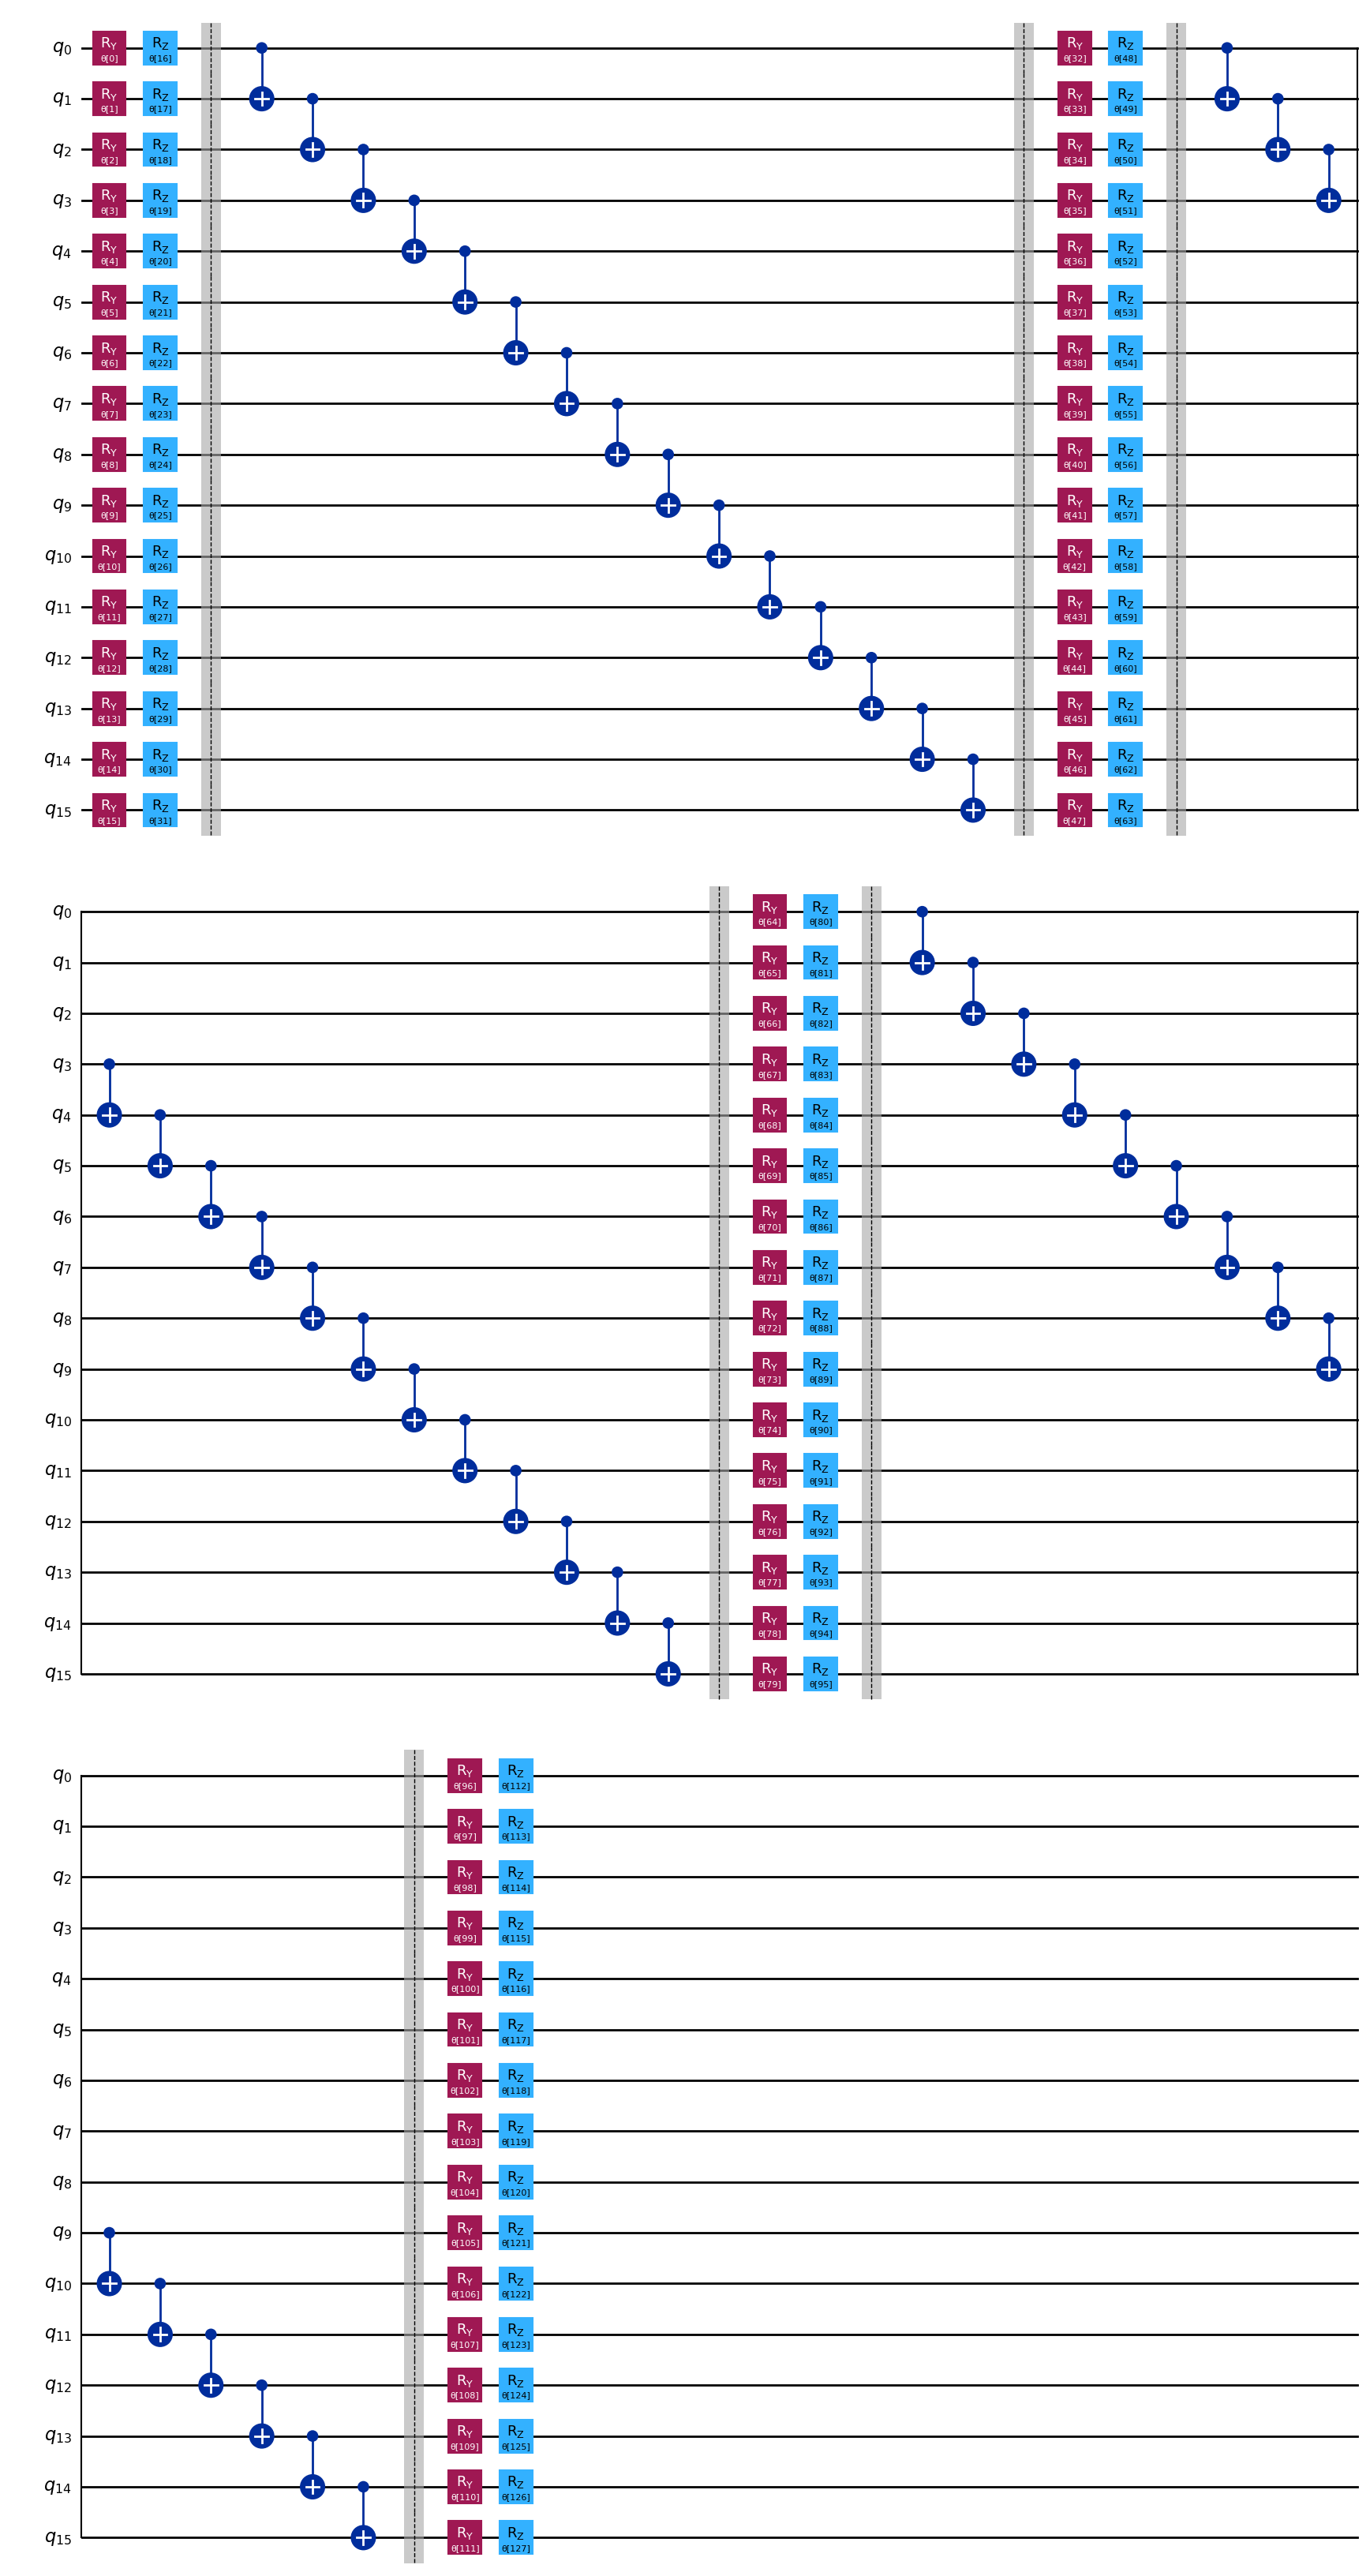

In [63]:
ansatz.decompose().draw("mpl")

In [64]:
# 5. 시뮬레이터 설정
print("\n[5단계] 양자 시뮬레이터 설정")
print("-" * 60)

backend = AerSimulator()
print(f"백엔드: {backend.name}")

# Estimator 설정 (Qiskit Primitives)
estimator = Estimator()


[5단계] 양자 시뮬레이터 설정
------------------------------------------------------------
백엔드: aer_simulator


In [65]:
# 6. Optimizer 설정
print("\n[6단계] Classical Optimizer 설정")
print("-" * 60)

#optimizer = SLSQP(maxiter=4082)
#print(f"Optimizer: SLSQP \n 최대 반복 횟수: 4082")

# 1. 가장 많이 쓰이고 안정적인 최적 선택 (추천 1순위), 본 AER사용 예제에서는 수렴못함
#optimizer = SPSA(maxiter=1000, learning_rate=0.1, perturbation=0.05, second_order=True)

# 2. 노이즈가 심한 실제 양자 하드웨어에서 가장 강력한 선택, 본 AER사용 예제에서는 수렴않됨
#optimizer = SPSA(maxiter=2000, blocking=False, allowed_increase=0.1, learning_rate=0.05,  perturbation=0.01,  second_order=True, resamplings={1: 10, 50: 5, 100: 3})

# 3. 시뮬레이터에서 빠르고 정확하게 수렴시키고 싶을 때 (추천), 본 AER사용 예제에서 최상의 결과
optimizer = COBYLA(maxiter=2000, tol=1e-7, rhobeg=1.0)

# 4. 시뮬레이터에서 가장 정확한 결과가 필요할 때, 본 AER사용 최고의 결과가 나옴
#optimizer = L_BFGS_B(maxfun=5000, maxiter=3000, ftol=1e-12, iprint=1)

# 5. QAOA에서 가장 많이 검증된 설정
#optimizer = NFT(maxiter=500, maxfev=10000)

# 6. 최신 Qiskit에서 성능 좋은 Gradient 기반 (Simulator 전용), 좋은 결과
#optimizer = P_BFGS(maxfun=10000, ftol=1e-9)


[6단계] Classical Optimizer 설정
------------------------------------------------------------


In [ ]:
# 7. VQE 실행
print("\n[7단계] VQE 알고리즘 실행")
print("-" * 60)
print("최적화 진행...")

# 현재 시간 보관 (시작 시간)
start_time = datetime.datetime.now()

# 현재 시작 시간 표시
print(f"루틴 시작 시간: {start_time.strftime('%H시 %M분 %S초')}")

# 초기 파라미터 설정
initial_point = np.random.random(ansatz.num_parameters)

#수렴과정을 그래프로 그리기 위해 중간 상태 보관
cost_history = []
def store_intermediate_result(eval_count, parameters, mean, std):
  # 루틴 종료 시간
  end_time = datetime.datetime.now()
  # 시작 시간과 종료 시간의 차이 계산
  time_diff = end_time - start_time

  # 시:분:초로 표시
  total_seconds = int(time_diff.total_seconds())
  hours = total_seconds // 3600
  minutes = (total_seconds % 3600) // 60
  seconds = total_seconds % 60

  #print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  print(eval_count," 단계: ", mean, f"\t\t총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")
  cost_history.append(mean)
###def

# VQE 인스턴스 생성
vqe = VQE(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    callback=store_intermediate_result
)

# VQE 실행
result = vqe.compute_minimum_eigenvalue(qubit_op)

print("최적화 완료!!!")

# 루틴 종료 시간
end_time = datetime.datetime.now()
print(f"루틴 종료 시간: {end_time.strftime('%H시 %M분 %S초')}")

# 시작 시간과 종료 시간의 차이 계산
time_diff = end_time - start_time

# 시:분:초로 표시
total_seconds = int(time_diff.total_seconds())
hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

print(f"총 실행 시간: {hours:02d}시 {minutes:02d}분 {seconds:02d}초")


[7단계] VQE 알고리즘 실행
------------------------------------------------------------
최적화 진행...
루틴 시작 시간: 07시 45분 54초
1  단계:  -38.135234034241904 		총 실행 시간: 00시 00분 01초
2  단계:  -42.005660174496946 		총 실행 시간: 00시 00분 02초
3  단계:  -43.94072615530008 		총 실행 시간: 00시 00분 04초
4  단계:  -40.72123832157897 		총 실행 시간: 00시 00분 06초
5  단계:  -44.12255489138997 		총 실행 시간: 00시 00분 08초
6  단계:  -43.80147676756261 		총 실행 시간: 00시 00분 09초
7  단계:  -44.54430483060114 		총 실행 시간: 00시 00분 10초
8  단계:  -44.76090614891299 		총 실행 시간: 00시 00분 12초
9  단계:  -45.20010348304036 		총 실행 시간: 00시 00분 13초
10  단계:  -45.512817336298525 		총 실행 시간: 00시 00분 15초
11  단계:  -45.52973467848056 		총 실행 시간: 00시 00분 16초
12  단계:  -45.57316640747616 		총 실행 시간: 00시 00분 18초
13  단계:  -45.758642258656536 		총 실행 시간: 00시 00분 20초
14  단계:  -45.74450423676192 		총 실행 시간: 00시 00분 21초
15  단계:  -45.758125764415276 		총 실행 시간: 00시 00분 23초
16  단계:  -45.75422739776921 		총 실행 시간: 00시 00분 24초
17  단계:  -45.81707673337036 		총 실행 시간: 00시 00분 25초
18  단계:  -43.914329965954

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o', linestyle='-', markersize=2)
plt.title('VQE Cost Function Convergence')
plt.xlabel('Optimization Step')
plt.ylabel('Cost Function Value (Ground State Energy)')
plt.grid(True)
plt.show()

In [ ]:
# 8. 결과 출력
print("\n" + "=" * 60)
print("VQE 결과")
print("=" * 60)

print(f"\n최적 에너지 (VQE): {result.eigenvalue.real:.6f} Hartree")
print(f"최적 파라미터 개수: {len(result.optimal_point)}")
print(f"Optimizer 평가 횟수: {result.cost_function_evals}")

In [ ]:
# 9. 정확한 해와 비교 (Classical 계산)
print("\n[비교] Classical Exact Eigensolver")
print("-" * 60)

from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
exact_result = numpy_solver.compute_minimum_eigenvalue(qubit_op)

print(f"정확한 에너지: {exact_result.eigenvalue.real:.6f} Hartree")

# 오차 계산
error = abs(result.eigenvalue.real - exact_result.eigenvalue.real)
print(f"\n에너지 오차: {error:.6f} Hartree")
print(f"상대 오차: {(error / abs(exact_result.eigenvalue.real)) * 100:.4f}%")

In [ ]:
# 10. 추가 정보
print("\n" + "=" * 60)
print("추가 정보")
print("=" * 60)

# 에너지를 다른 단위로 변환 (Hartree to eV)
hartree_to_ev = 27.211386245988
vqe_energy_ev = result.eigenvalue.real * hartree_to_ev
exact_energy_ev = exact_result.eigenvalue.real * hartree_to_ev

print(f"\nVQE 에너지: {vqe_energy_ev:.6f} eV")
print(f"정확한 에너지: {exact_energy_ev:.6f} eV")

print("\n" + "=" * 60)
print("계산 완료!")
print("=" * 60)